# Packages

In [1]:
import numpy as np 
import pandas as pd 
import csv
import re, string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import matplotlib.pyplot as plt
%matplotlib inline
 
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS 
import pickle
from sklearn import tree


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
!pip install mlxtend
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from nltk.stem import WordNetLemmatizer 
from sklearn.ensemble import VotingClassifier


#!pip install gensim
import gensim
from gensim.models import Word2Vec
import logging
  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarangshaikh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sarangshaikh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading Data

In [2]:
train_data=pd.read_csv("../fake_or_real_news.csv", delimiter=',')
train_data.head(5)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


# Exploratory Data Analysis

In [3]:
#total number of instances
print('There are', len(train_data), 'data points.')

There are 6335 data points.


In [4]:
#attributes in datasets
for i, col in enumerate(train_data.columns):
    print(i, col)

0 Unnamed: 0
1 title
2 text
3 label


REAL    3171
FAKE    3164
Name: label, dtype: int64


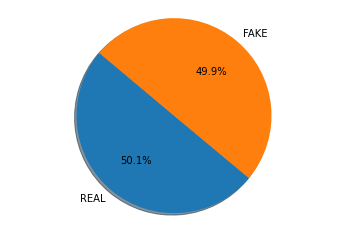

In [5]:
#distribution of polarity column
print(train_data['label'].value_counts())


# Pie chart, where the slices shows the distribution of polarity column:
labels = 'REAL','FAKE'
sizes = train_data['label'].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=140)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [6]:
#calculating the length of sentences in text column 
train_data['length']=train_data['text'].apply(len)
train_data.head()

,Unnamed: 0,title,text,label,length
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,7518
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,2646
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,2543
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,2660
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1840


In [10]:

train_data[train_data['length']==  119]['text'].iloc[0]


'The first time I went, and was completely taken by the live jazz band and atmosphere, I ordered the Lobster Cobb Salad.'

<AxesSubplot:ylabel='Frequency'>

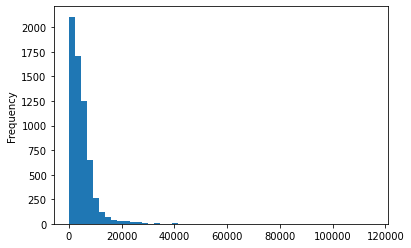

In [7]:
train_data['length'].plot(bins=50,kind='hist')

# Preprocessing 

In [8]:

def text_process(text):

    text = text.lower()    
        
    #Remove white space
    text = text.strip()    
    #Remove hashtags
    text = re.sub(r'#([^\s]+)', '', text)   
    #Remove stopwords
    text = " ".join([word for word in text.split(' ') if word not in stopwords.words('english')])
    #Remove punctuation
    text = "".join(l for l in text if l not in string.punctuation)
    
    return text


In [10]:
train_data_subset = train_data
train_data_subset['text']=train_data_subset['text'].apply(text_process)
train_data_subset.head(10)

,Unnamed: 0,title,text,label,length
0,8476,You Can Smell Hillary’s Fear,daniel greenfield shillman journalism fellow f...,FAKE,7518
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stumbleu...,FAKE,2646
2,3608,Kerry to go to Paris in gesture of sympathy,us secretary state john f kerry said monday st...,REAL,2543
3,10142,Bernie supporters on Twitter erupt in anger ag...,— kaydee king kaydeeking november 9 2016 lesso...,FAKE,2660
4,875,The Battle of New York: Why This Primary Matters,primary day new york frontrunners hillary clin...,REAL,1840
5,6903,"Tehran, USA",i’m immigrant grandparents are 50 years ago ar...,FAKE,13333
6,7341,Girl Horrified At What She Watches Boyfriend D...,share baylee luciani left screenshot baylee ca...,FAKE,3171
7,95,‘Britain’s Schindler’ Dies at 106,czech stockbroker saved 650 jewish children na...,REAL,783
8,4869,Fact check: Trump and Clinton at the 'commande...,hillary clinton donald trump made inaccurate c...,REAL,13863
9,2909,Iran reportedly makes new push for uranium con...,iranian negotiators reportedly made lastditch ...,REAL,4296


In [11]:
#word cloud for text 
df = train_data_subset
  
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

KeyboardInterrupt: 

In [12]:
def check_eng(word):
    if wordnet.synsets(word):
        return True

def identify_tokens(train_data_subset):
    text = train_data_subset['text']
    tokens = nltk.word_tokenize(text)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha() and check_eng(w) == True]
    return token_words

train_data_subset['Text_Words'] = train_data_subset.apply(identify_tokens, axis=1)

In [13]:
lemmatizer = WordNetLemmatizer() 
def lemm_list(train_data_subset):
    my_list = train_data_subset['Text_Words']
    lemitized_list = [lemmatizer.lemmatize(word) for word in my_list]
    return (lemitized_list)

train_data_subset['lemmed_words'] = train_data_subset.apply(lemm_list, axis=1)

In [14]:
print(train_data_subset['lemmed_words'])

0       [daniel, journalism, fellow, freedom, center, ...
1       [google, print, delicious, pocket, there, two,...
2       [u, secretary, state, john, f, said, monday, s...
3       [king, november, lesson, tonight, loss, time, ...
4       [primary, day, new, york, hillary, clinton, tr...
                              ...                        
6330    [state, department, told, republican, national...
6331    [p, pb, stand, plutocratic, pentagon, posted, ...
6332    [protester, tool, oligarchy, always, provokes,...
6333    [ethiopia, convened, meeting, leader, several,...
6334    [bush, suddenly, attacking, trump, here, matte...
Name: lemmed_words, Length: 6335, dtype: object


In [15]:
#rejoin words

def rejoin_words(train_data_subset):
    my_list = train_data_subset['lemmed_words']
    joined_words = ( " ".join(my_list))
    return joined_words

train_data_subset['processed'] = train_data_subset.apply(rejoin_words, axis=1)

In [16]:
train_data_subset['processed'].head()

0    daniel journalism fellow freedom center new yo...
1    google print delicious pocket there two fundam...
2    u secretary state john f said monday stop pari...
3    king november lesson tonight loss time democra...
4    primary day new york hillary clinton trump lea...
Name: processed, dtype: object

In [18]:
train_data_subset.to_csv('../fake_or_real_news_cleaned.csv', index=False)

# Training Model Using Bigram with TFIDF

# Feature Engineering 

In [19]:
vectorisor = CountVectorizer(ngram_range = (1, 2),decode_error="replace")
vec_train =vectorisor.fit_transform(train_data_subset['processed'])

pickle.dump(vectorisor.vocabulary_,open("Models/feature_bigram.pkl","wb"))

In [20]:
transformer=TfidfTransformer()
loadede_vec=CountVectorizer(decode_error="replace",vocabulary=pickle.load(open("Models/feature_bigram.pkl","rb")))
tfidf=transformer.fit_transform(loadede_vec.fit_transform(train_data_subset['processed']))

# Performance of Classifiers Using Train Test Split 

In [25]:
#Data Splitting into Train Test Sets
X_train, X_test, y_train, y_test = train_test_split(tfidf, train_data_subset['label'], test_size=0.2, random_state=42)

a, b = np.unique(y_test,return_counts=True)
print(a)
print(b)

a, b = np.unique(y_train,return_counts=True)
print(a)
print(b)

['FAKE' 'REAL']
[628 639]
['FAKE' 'REAL']
[2536 2532]


lr : 0.9163378058405682

Classification Report: 
               precision    recall  f1-score   support

        FAKE       0.90      0.94      0.92       628
        REAL       0.94      0.90      0.92       639

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267




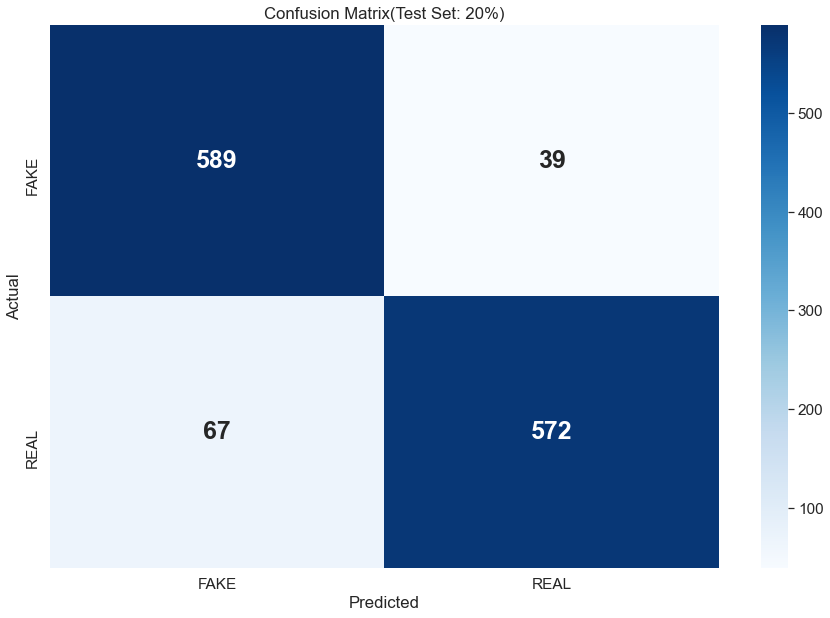

mnb : 0.7561168113654302

Classification Report: 
               precision    recall  f1-score   support

        FAKE       0.99      0.51      0.68       628
        REAL       0.67      1.00      0.80       639

    accuracy                           0.76      1267
   macro avg       0.83      0.75      0.74      1267
weighted avg       0.83      0.76      0.74      1267




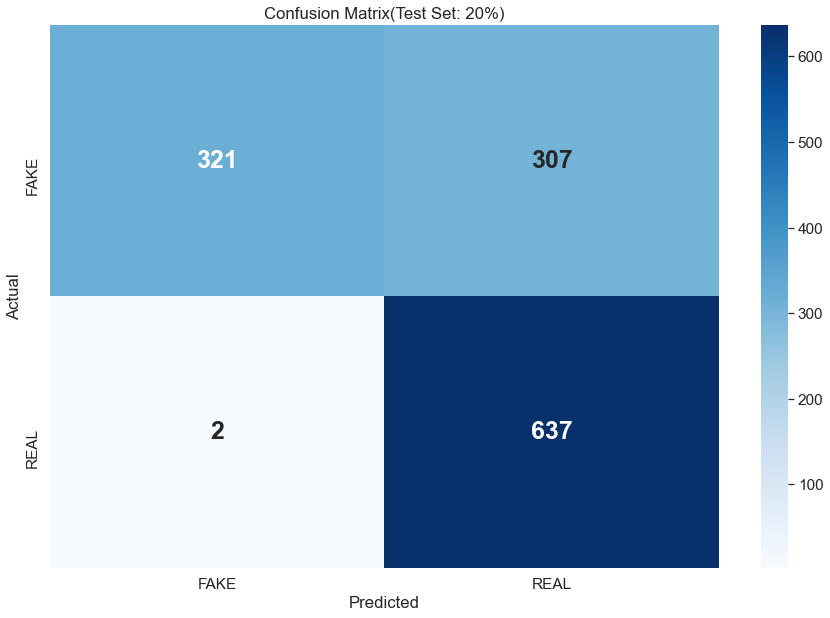

rfc : 0.8697711128650355

Classification Report: 
               precision    recall  f1-score   support

        FAKE       0.86      0.88      0.87       628
        REAL       0.88      0.86      0.87       639

    accuracy                           0.87      1267
   macro avg       0.87      0.87      0.87      1267
weighted avg       0.87      0.87      0.87      1267




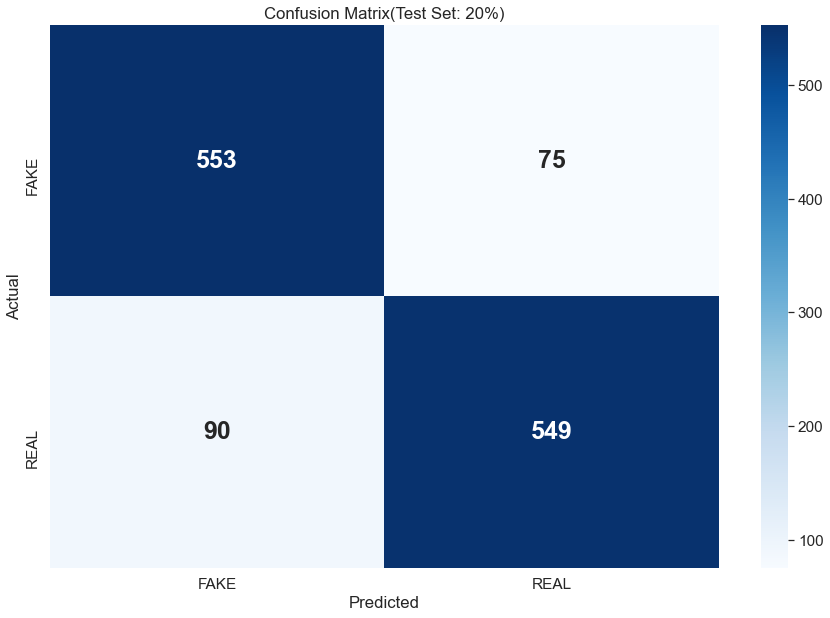

svm : 0.9297553275453828

Classification Report: 
               precision    recall  f1-score   support

        FAKE       0.92      0.94      0.93       628
        REAL       0.94      0.92      0.93       639

    accuracy                           0.93      1267
   macro avg       0.93      0.93      0.93      1267
weighted avg       0.93      0.93      0.93      1267




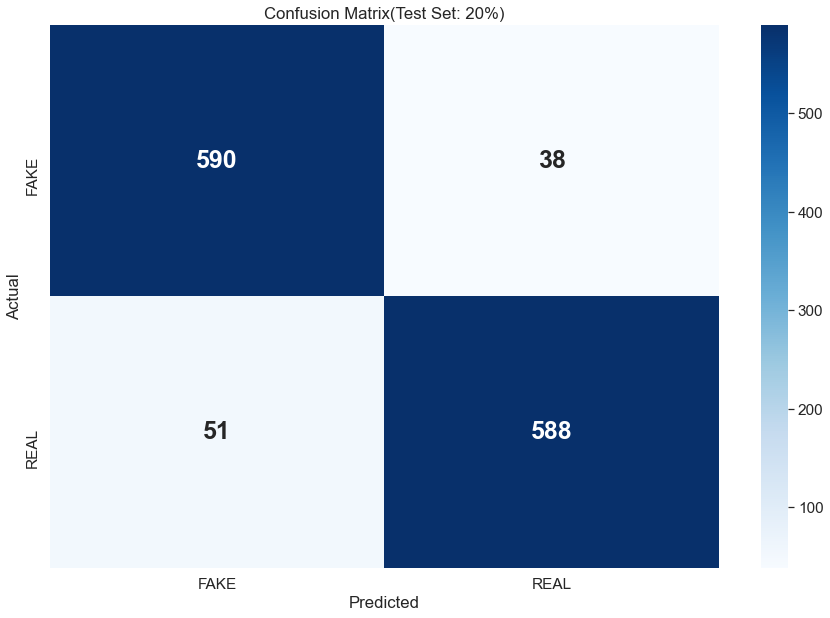

Ensamble : 0.930544593528019

Classification Report: 
               precision    recall  f1-score   support

        FAKE       0.91      0.95      0.93       628
        REAL       0.95      0.91      0.93       639

    accuracy                           0.93      1267
   macro avg       0.93      0.93      0.93      1267
weighted avg       0.93      0.93      0.93      1267




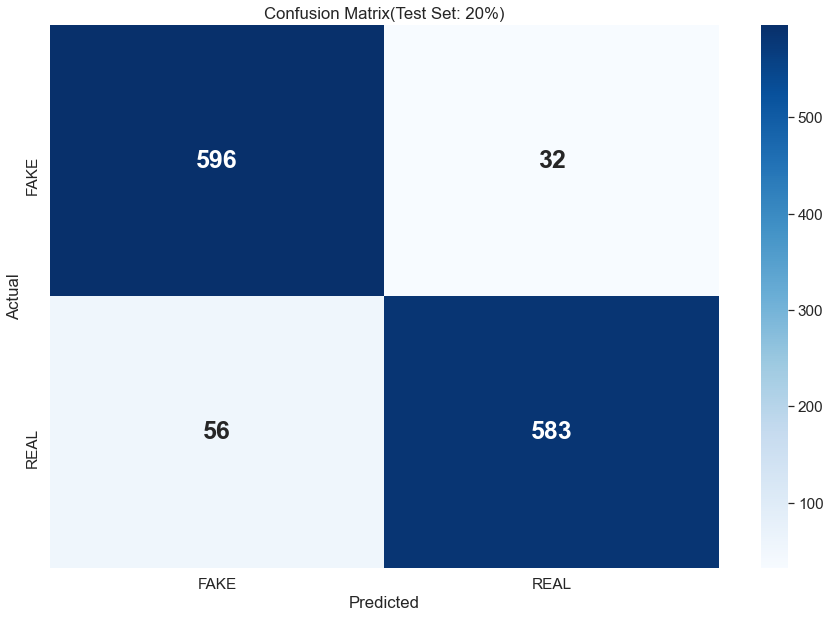

In [32]:

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

clfs = {
        'lr': LogisticRegression(), 
        'mnb': MultinomialNB(),   
        'rfc': RandomForestClassifier(), 
        'svm': SVC(kernel = 'linear', probability = True),
        'Ensamble' : VotingClassifier(estimators=[('lr', LogisticRegression()), 
                                                  ('rf', RandomForestClassifier()),
                                                  ('svm', SVC(kernel = 'linear', probability = True))], voting='hard')
 
       }

def test_clf(clf_dict, Xtrain, ytrain):
    for clf_name, clf in clf_dict.items():
        model = clf.fit(Xtrain, ytrain)
        filename = 'Models/'+clf_name+'_final.sav'
        pickle.dump(model, open(filename, 'wb'))
        predicted = clf.predict(X_test)
        print(clf_name,":",np.mean(predicted == y_test))
        print()
        print("Classification Report: \n",classification_report(y_test, predicted))
        print() 
        labels = ['FAKE', 'REAL']
        cm = confusion_matrix(y_test,predicted)
        df_cm = pd.DataFrame(cm, labels, labels)
        plt.figure(figsize=(15,10))
        sn.set(font_scale=1.4) # for label size
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 25, "weight":"bold"}, cmap='Blues', fmt='d') # font size
        plt.title('Confusion Matrix(Test Set: 20%)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
      
       
        
        
        
test_clf(clfs, X_train, y_train)